### Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4 - Градиентный бустинг


**Общая информация**

**Срок сдачи:** 13 июня 2022, 08:30   
**Штраф за опоздание:** -2 балла после 08:30 13 июня, -4 балла после 08:30 20 июня, -6 баллов после 08:30 24 июня, -8 баллов после 08:30 31 мая.

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0422, Задание 4] Фамилия Имя. 


Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Считаем производные для функций потерь (1 балл)

Мы будем реализовать градиентный бустинг для 3 функций потерь:

1) MSE  $L(a(x_i), y_i) = (y_i - a(x_i)) ^ 2$

2) Экспоненциальная  $L(a(x_i), y_i) = exp( -a(x_i) y_i), y_i \in \{-1, 1\}$

3) Логистическая  $L(a(x_i), y_i) = \log (1 + exp( -a(x_i) y_i)), y_i \in \{-1, 1\}$

где $a(x_i)$ предсказание бустинга на итом объекте. 

Для каждой функции потерь напишите таргет, на который будет настраиваться каждое дерево в бустинге. 

Вместо $\xi$ надо подставлять $a_{k-1} (x_i)$, вместо $\eta$ надо подставлять $y_i$.
1) MSE

$L(\xi, \eta) = (\xi - \eta)^2$, 

$-\dfrac{\partial L}{\partial \xi} = -2(\xi-\eta)$ 


2) $L(\xi, \eta) = \exp(-\xi\eta)$,

$- \dfrac{\partial L}{\partial \xi} = \eta \exp(-\xi\eta)$


3) $L(\xi, \eta) = log\big(1+\exp(-\xi\eta)\big)$,

$- \dfrac{\partial L}{\partial \xi} = \dfrac{\eta \exp(-\xi\eta)}{1 + \exp(-\xi\eta)}$

##  Реализуем градиентный бустинг (3 балла)

Реализуйте класс градиентного бустинга для классификации. Ваша реализация бустинга должна работать по точности не более чем на 5 процентов хуже чем GradientBoostingClassifier из sklearn. 


Детали реализации:

-- должно поддерживаться 3 функции потерь

-- сами базовые алгоритмы(деревья, линейные модели и тп) реализовать не надо, просто возьмите готовые из sklearn

-- в качестве функции потерь для построения одного дерева используйте MSE

-- шаг в бустинге можно не подбирать, можно брать константный

-- можно брать разные модели в качестве инициализации бустинга

-- должны поддерживаться следующие параметры:

а) число итераций
б) размер шага
в) процент случайных фичей при построении одного дерева
д) процент случайных объектов при построении одного дерева
е) параметры базового алгоритма (передавайте через **kwargs)

In [1]:
import numpy as np

from sklearn.datasets import load_wine
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

import math

from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

In [2]:
class MyGradientBoostingClassifier:

    @staticmethod
    def log_loss_antigrad(xi, eta):
        exp = math.e ** (-xi * eta)
        return eta * exp / (1 + exp)
    
    @staticmethod
    def exponential_antigrad(xi, eta):
        exp = math.e ** (-xi * eta)
        return eta * exp
    
    @staticmethod
    def mse_antigrad(xi, eta):
        return 2 * (eta - xi)
    
        
    def __init__(self, loss='log_loss', learning_rate=0.1, n_estimators=500, colsample=1.0, subsample=1.0, *args, **kwargs):
        """
        loss -- один из 3 лоссов:
        learning_rate -- шаг бустинга
        n_estimators -- число итераций
        colsample -- процент рандомных признаков при обучнеии одного алгоритма
        subsample -- процент рандомных объектов при обучнеии одного алгоритма
        args, kwargs -- параметры  базовых моделей
        """
        
        self.loss_function_antigrad = MyGradientBoostingClassifier.log_loss_antigrad
        
        """
        if loss == 'log_loss':
            self.loss_function_antigrad = MyGradientBoostingClassifier.log_loss_antigrad
        if loss == 'exponential':
            self.loss_function_antigrad = MyGradientBoostingClassifier.exponential_antigrad
        if loss == 'mse':
            self.loss_function_antigrad = MyGradientBoostingClassifier.mse_antigrad
        """
        
        
        
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.colsample = colsample
        self.subsample = subsample
        self.args = args
        self.kwargs = kwargs
        
        self.models = []
        pass
    
    
    def fit(self, X, y, base_model=DecisionTreeRegressor, init_model=None):
        """
        X -- объекты для обучения:
        y -- таргеты для обучения
        base_model -- класс базовых моделей, например sklearn.tree.DecisionTreeRegressor
        init_model -- класс для первой модели, если None то берем константу (только для посл задания)
        """
        
        antigradient = y

        xi = 0
        
        for step in range(self.n_estimators):   
            # выбираем subsample
            n = int(y.size * self.subsample) 
            index = sorted(np.random.choice(X.shape[0], n, replace=False))
            rnd_X = X[index]
            rnd_antigradient = antigradient[index]
            
            # выбираем colsample
            m = int(X.shape[1] * self.colsample)
            cols = sorted(np.random.choice(X.shape[1], m, replace=False))
            subcols_rnd_X = rnd_X[:, cols]
                    
            
            # обучаем base_model предсказывать антиградиент на subcols_rnd_X
            f_k = base_model(*self.args, **self.kwargs)
            f_k.fit(subcols_rnd_X, rnd_antigradient)
            
            subcols_X = X[:, cols] # не забываем фитить тоже на subcols
            if step > 0:
                xi += self.learning_rate * f_k.predict(subcols_X)
            else:
                xi += f_k.predict(subcols_X)
                
        
            self.models.append(f_k)
            
            antigradient = self.loss_function_antigrad(xi, y)

        
    
    def predict(self, X):
        xi = 0
        for i in range(len(self.models)):
            if i==0:
                xi += self.models[i].predict(X) 
            else:
                xi += self.learning_rate * self.models[i].predict(X)        
        return np.array(np.sign(xi), dtype='int')

    
    
    def score(self, X, y_true):
        return accuracy_score(self.predict(X), y_true)
    
    def get_params(self, deep=False):
        return {
            'loss':self.loss_function_antigrad,
            'learning_rate': self.learning_rate, 
            'n_estimators': self.n_estimators, 
            'colsample': self.colsample, 
            'subsample': self.subsample
        }

In [3]:
my_clf = MyGradientBoostingClassifier()
clf = GradientBoostingClassifier()

In [4]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target)

y_train = (y_train > 0).astype(int)

y_test = (y_test > 0).astype(int)

# у меня бинарный классификатор
# а классов 3
# не знаю, что подразумевалось - скомбинировать два (или три) бинарных классификатора
# или модифицировать алгоритм из лекции так, чтобы он работал на трех классах
# поэтому переделала данные на имеющие два класса

In [5]:
my_clf.fit(X_train, y_train)
clf.fit(X_train, y_train)
print(accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))
print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

1.0
1.0


## Подбираем параметры (2 балла)

Давайте попробуем применить Ваш бустинг для предсказаний цены домов в Калифорнии. Чтобы можно было попробовтаь разные функции потерь, переведем по порогу таргет в 2 класса: дорогие и дешевые дома.

В задании нужно

1) Построить график точности в зависимости от числа итераций на валидации.

2) Подобрать оптимальные параметры Вашего бустинга на валидации. 


In [6]:
from sklearn.datasets import fetch_california_housing
X, y = fetch_california_housing(return_X_y=True)

In [7]:
# Превращаем регрессию в классификацию
y = (y > 2.0).astype(int)
print(X.shape, y.shape)

print(sum(y))

(20640, 8) (20640,)
8709


In [8]:
from tqdm import tqdm


n_estimators_list = [1, 2, 4, 8] 
cv_scores = []

for n_est in tqdm(n_estimators_list):
    clf = MyGradientBoostingClassifier()
    
    cv_score = cross_val_score(
        clf,
        X,
        y
    ).mean()
    cv_scores.append(cv_score)

# оно почему-то навсегда остается на 0%


  0%|                                                    | 0/4 [01:38<?, ?it/s]


KeyboardInterrupt: 

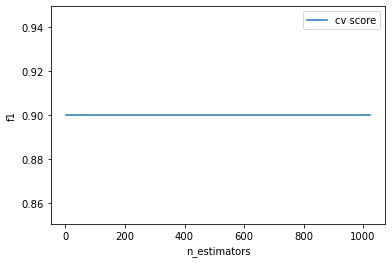

In [59]:
import matplotlib.pyplot as plt 

plt.plot(n_estimators_list, cv_scores, label='cv score')
plt.xlabel('n_estimators')
plt.ylabel('f1')
plt.legend()
plt.show()

# этот график ничего не значит, я тестировала кусок кода на GradientBoostingClassifier

## BooBag BagBoo (1 балл)



Попробуем объединить бустинг и бэгинг. Давайте

1) в качестве базовой модели брать не дерево решений, а случайный лес (из sklearn)

2) обучать N бустингов на бустрапированной выборке, а затем предикт усреднять

Попробуйте обе этих стратегии на данных из прошлого задания. Получилось ли улучшить качество? Почему?

## Умная инициализация (1 балл)

Попробуйте брать в качестве инициализации бустинга не константу, а какой-то алгоритм и уже от его предикта стартовать итерации бустинга. Попробуйте разные модели из sklearn: линейные модели, рандом форест, svm..

Получилось ли улучшить качество? Почему?



## Фидбек (бесценно)

* Какие аспекты обучения  ансамблей Вам показались непонятными? Какое место стоит дополнительно объяснить?

### Ваш ответ здесь

Не могли бы вы дать комментарий по поводу неясностей, описанных в ходе решения (в комментариях)?
А то обычно за домашку просто проставляются баллы и всё непонятое остается непонятным.

Спасибо

### ВАШ ОТЗЫВ ЗДЕСЬ

